# Modelisation : Decision Tree Classifier, Dataset choisi : Diabetes Dataset

Afin de pouvoir faire notre analyse avec les outils les plus adaptés, nous allons commencer par importer toutes les librairies nescessaires à notre études, certaines n'étant pas installées de base, nous les installons sur notre machine via les fonctions "pip install"



In [ ]:
!pip install graphviz #installing the library for trees visualization
!pip install pydotplus #installing the library for tree visualization too
!pip install category_encoders #installing the library for tree visualization also

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd #import pandas to manipulate DataFrame
import numpy as np #import numpy for mathematical functions
import matplotlib.pyplot as plt #import matplotlib for visualization
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from category_encoders import OrdinalEncoder #import encoder for the target variable
from sklearn import tree #importing tree for classification
from sklearn.metrics import confusion_matrix #importing confusion matrix in order to get metrics about the results
from sklearn import metrics #getting the metrics library to compare the different models
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve #importing the differents metrics for comparaison
from sklearn.model_selection import cross_val_score #function for cross validation scores
from sklearn.metrics import f1_score #function that compute the f1 score
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline #module to create the pipeline to test the different hyperparameters
from sklearn.model_selection import GridSearchCV #tool in order to detect the best model by testing the different options
from sklearn.metrics import f1_score, make_scorer

## Etape 1 : import des données, adaptation et visualisation du dataset

on va commencer par importer le jeu de données en utilisant la librairie pandas afin de manipuler un dataframe, c'est un type de données qui permet un traitement plus simple des jeu de données sous python, on commence donc par lire le dataset et visualiser grossièrement les données (moyenne, variance etc...). On s'intéresse également au type des différentes données afin de potentiellement les retravailler pour que ce soit plus simple pour la suite.

In [ ]:
df=pd.read_csv('/content/4 diabetes.csv', sep=';') #reading the csv to import content

In [ ]:
print(df.head(),df.tail()) #displaying the first information of the dataframe
print(df.describe()) #visualizing the basic information about the dataset
print('Here is the shape of our Data frame ' '' + str(df.shape)+ '') #printing the shape of the Data Frame
print(df.info()) #printing information about the different columns of the dataset

   preg  plas  pres  skin  insu  mass   pedi  age            class
0     6   148    72    35     0  33.6  0.627   50  tested_positive
1     1    85    66    29     0  26.6  0.351   31  tested_negative
2     8   183    64     0     0  23.3  0.672   32  tested_positive
3     1    89    66    23    94  28.1  0.167   21  tested_negative
4     0   137    40    35   168  43.1  2.288   33  tested_positive      preg  plas  pres  skin  insu  mass   pedi  age            class
763    10   101    76    48   180  32.9  0.171   63  tested_negative
764     2   122    70    27     0  36.8  0.340   27  tested_negative
765     5   121    72    23   112  26.2  0.245   30  tested_negative
766     1   126    60     0     0  30.1  0.349   47  tested_positive
767     1    93    70    31     0  30.4  0.315   23  tested_negative
             preg        plas        pres        skin        insu        mass  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120

Lors de la visualisation basique, on se rend compte de plusieurs choses:  

1) Notre dataset est composé de variable quantitative pour les features (les prédicteurs en françis) et que notre  target variable (variable cible) est elle de type binaire (0 ou 1). Toutefois cette variable est pour le moment encodé selon un type de variable "string" ainsi afin de permettre à l'ordinateur de bien l'interpréter, nous allons l'encoder suivant le schéma de mapping de la variable comme dans la suite du code. Nous verifirons ensuite que le changement a bien été effectué en revisualisant les info du dataframe. 

2) On voit également que l'on a 767 lignes dans notre Dataset, ce nombre de données est assez grand pour pouvoir faire un dataset de validation assez grand pour pouvoir les utiliser pour interpréter les résultats ainsi nous séparerons par la suite notre jeu de données avec un rapport de 70/30  entre le jeu de données d'entrainement (training set) et du jeu de données de test (testing set)

3) On a également la possibilité de voir que l'on a 8 colonnes de prédicteurs ce qui nous permet d'avoir différentes variables auxquelles on va s'intéresser.

In [ ]:
mapping = [{'col': 'class', 'mapping': {"tested_positive": 1,  "tested_negative": 0,}}] #setting the dictionnary in order to encode our target variables
df=OrdinalEncoder(cols=['class'], mapping=mapping).fit(df).transform(df) #encoding with the dictionnary

In [ ]:
print(df.info()) #displaying info to verify the encoding proces

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


On voit donc bien que la colonne class est passée d'une variable de type "object" à une variable de type "int64" (entier codé sur 64 bits), notre "target variable" est donc bien interprétable par l'ordinateur.

# Visualisation des données et de leur répartition

afin de comprendre nos prédictions il est important de s'intéresser à la forme que prend notre dataset, quelles est la répartition suivant les différents variables, ces données sont-elles représentatives ? Ces dernières vont servir à alimenter notre modèle il faut donc voir si elles reflètent quelque chose de pertinent et pouvoir voir dès le départ si elle peuvent comporter un certain biais qui pourrait toucher à la robustesse de notre modèle.

Nous avons donc créer une petite fonction qui permet de visualiser la répartition de nos variables afin d'avoir une idée plus générale du jeu de données et son comportement. 

In [ ]:
L=df.columns.to_list() #takings all the different columns name
def histo(column): #creating the function for the histogram
  plt.hist(df[column],bins=50) #plotting the histogram with the intervals divided into 50 equal size bins
  plt.title(column) #setting up the title as the name of the column
  plt.xlabel(' Values of the occurences ' + str(column)+ '') #setting xlabels
  plt.ylabel("Number of occurences in the dataset") #setting y labels
  plt.savefig('Histogram of : ' +str(column), dpi=300) #saving the figures
  plt.show() #printing the different figures

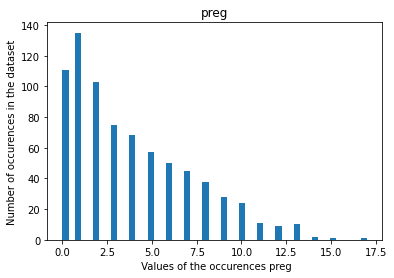

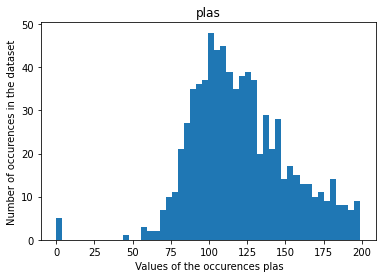

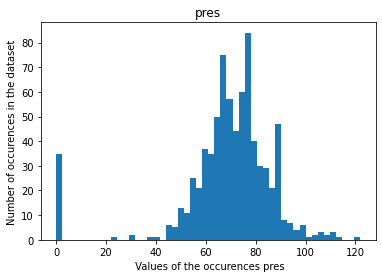

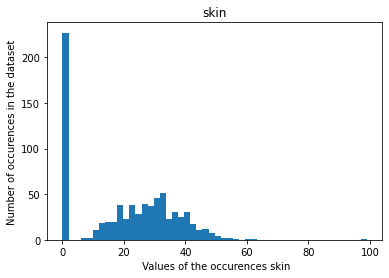

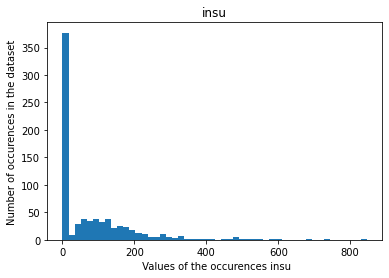

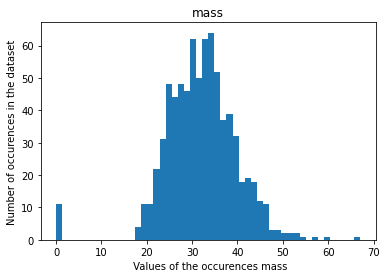

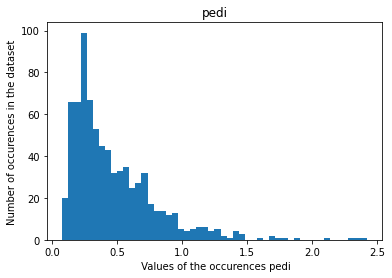

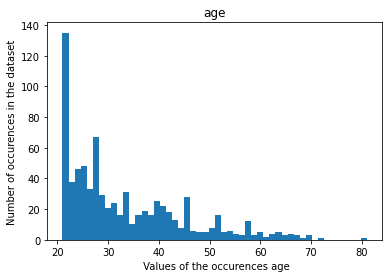

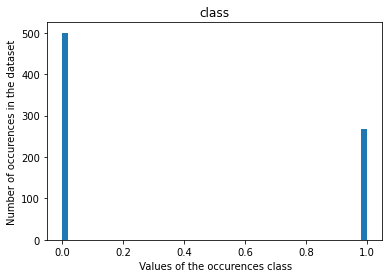

In [ ]:
for i in L:  #creating a list with all the columns
  histo(i) #boxplotting the different columns

Suite à ces différentes visualisations, on peut observer différentes choses:

1) On voit que la répartition suivant notre variable d'arrivée est environ de 2/3 de negatif, 1/3  de negatif, notre dataset n'est donc pas balancé, on pourrait donc dans un objectif d'amélioration de performance, essayer de rendre le training set balancé afin de pouvoir améliorer les prédictions, cependant dans notre cas pour éviter de biaiser notre modèle nous ne modifirons pas la répartition et essaierons de conserver cette proportion lors de la séparation en training set et testing set.

2) On observe que le dataset est majoritairement composé de personnes ayant un age autour des 40 ans, toutefois les significations des colonnes ne nous étant pas communiquées il est compliqué d'interpreter la répartition suivant les autres variables même si il aurait été intéressant de le faire !

# Visualsation des corrélations

Maintenant que l'on voit un peu mieux comment se comporte chaque variable, nous allons nous intéresser aux intéractions entre les différentes variables, nottament via l'analyse des différentes corrélations entres ces dernières. on va donc regarder la correlation des différentes variables suivant notre variable cible (Target variable)

In [ ]:
df.corr() #computing the correlation matrix of the different variables

,preg,plas,pres,skin,insu,mass,pedi,age,class
preg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
plas,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
pres,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skin,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insu,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
mass,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedi,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
class,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [ ]:
corre=df.corr().iloc[-1].sort_values(ascending=False)[1:] #selecting the class row and display the values by descending order
print(corre) #printing it

plas    0.466581
mass    0.292695
age     0.238356
preg    0.221898
pedi    0.173844
insu    0.130548
skin    0.074752
pres    0.065068
Name: class, dtype: float64


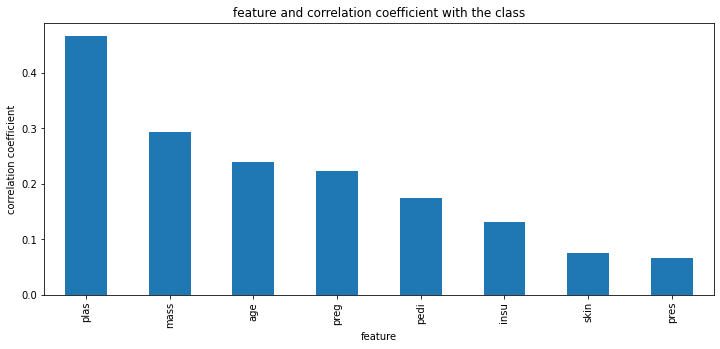

In [ ]:
plt.figure(figsize=(12, 5)) #setting the figure size
labels = [f"{i}" for i in corre.index.to_list()] #extracting the different label
ax = corre.plot(kind="bar") #ploting the different bars
ax.set_title("feature and correlation coefficient with the class") #setting the tittle
ax.set_xlabel("feature") #setting de x labels
ax.set_ylabel("correlation coefficient") #setting the y label
ax.set_xticklabels(labels) # setting the x ticks labels
plt.savefig('Feature and correlation coefficient for class',dpi=300) #saving the figure
plt.show() #showing the graph

On voit donc qu'il existe des corrélations entre nos variables et la variable cible, on voit nottament que "plas" a nottament une valeur prépondérante par rapport aux autres, ainsi si l'on poussait une analyse plus profonde de l'information contenu dans cette variable, un spécialiste pourrait surement nous expliquer la raison de cette correlation positive. On voit que la plupart des variables sont corrélées avec notre variable cible. 

# Préparation de l'entrainement

Maintenant que nous savons un peu plus quelles sont nos données et comment elles se comportent, nous pouvons préparer la creation d'un classifier qui s'appuierait sur ces dernières, on va donc commencer par séparer notre jeu de données en essayant de conserver les caractéristiques propres de notre dataset (nottament la répartition de 0 et 1 suivant notre variable cible). afin de valider au mieux notre modèle dans le futur, on va également creer un training set et un testing set avec un rapport 70/30 afin d'éviter tout risque de biais supplémentaires suite à l'apprentissage. 

In [ ]:
dfexp=df.copy() #creating a copy of the dataframe
yexp=dfexp['class'] #selecting the target variables
xexp=dfexp.drop(['class'],axis=1) #selecting the features only
# Split dataset into training set and test set

X_train,X_test,y_train,y_test= train_test_split(xexp,yexp,test_size=0.3, random_state=42, shuffle=True, stratify=df['class']) #splitting into different values in order to go quicker in the computation selecting only 30% of the data

print(y_test)

print("Here is the proportion of positive on the target variable in the testing set " +str(y_test.value_counts()[1]/(y_test.value_counts()[1]+y_test.value_counts()[0])) +'')
print("Here is the proportion of positive on the target variable in the training set " +str(y_train.value_counts()[1]/(y_train.value_counts()[1]+y_train.value_counts()[0])) +'')


print(X_train,y_train) #printing training data 
print(X_test,y_test) #printing testing data


730    1
198    1
24     1
417    1
387    1
      ..
94     0
437    0
86     0
221    1
19     1
Name: class, Length: 231, dtype: int64
Here is the proportion of positive on the target variable in the testing set 0.35064935064935066
Here is the proportion of positive on the target variable in the training set 0.34823091247672255
     preg  plas  pres  skin  insu  mass   pedi  age
209     7   184    84    33     0  35.5  0.355   41
176     6    85    78     0     0  31.2  0.382   42
147     2   106    64    35   119  30.5  1.400   34
454     2   100    54    28   105  37.8  0.498   24
636     5   104    74     0     0  28.8  0.153   48
..    ...   ...   ...   ...   ...   ...    ...  ...
214     9   112    82    32   175  34.2  0.260   36
113     4    76    62     0     0  34.0  0.391   25
556     1    97    70    40     0  38.1  0.218   30
759     6   190    92     0     0  35.5  0.278   66
107     4   144    58    28   140  29.5  0.287   37

[537 rows x 8 columns] 209    1
176    0
1

# Séléction des modèles les plus performants avant une analyse plus pousée

Afin d'avoir le modèle le plus optimal possible, nous allons utiliser un algorithme de Grid search afin de pouvoir entrainer différents modèles et comparer leurs scores avant de comparer les meilleurs d'entre eux. 

On va donc entrainer différents arbres de décision avec des paramètres que l'on aura choisi et on comparera leurs scores.

on va donc essayer :

1) différentes fonctions pour l'impureté de notre arbre (Gini, Entropy)

2) différentes profondeurs  pour notre arbre (de 1 à 8 comme profondeur maximale)

3) différentes feuilles minimums d'échantillonage pour  transformer un noeud en feuille lorsqu'il y a trop peu de données après ce dernier. On fera varier ce paramètres de 1 à 8.

4) différentes impuretés minimales afin d'appliquer un prunning de notre arbre 

On va donc créer une pipeline qui va nous permettre de créer les différents modèles suivant un dictionnaire de paramètres que l'on va créer, la fonction grid search va ensuite s'occuper d'itérer sur tous les modèles les entrainements, les crossvalidations et les calculs de différents score avant de nous renvoyer toutes les informations concernant les différents modèles et nous permettre de choisir les plus performants d'un point de vue du score ! En tant que score nous prendrons principalement un score F1, nous devrons donc définir ce scorer, toutefois il aurait pu être intéressant d'utiliser le recall également car dans notre cas nous chercherons à prédire au mieux les personnes positives quitte a augmenter le nombre de faux positif, comme on dit vaut mieux prévenir que guerir !

In [ ]:
f1 = make_scorer(f1_score, average = 'macro') #creating a scorer on F1 in order to use it as a scoring method

In [ ]:
dec_tree = tree.DecisionTreeClassifier(random_state=42) #creating the kind of model on wich we want to test the hyperparameters

In [ ]:
pipe = Pipeline(steps=[('dec_tree', dec_tree)]) #setting up the pipeline

criterion = ['gini', 'entropy'] #choosing the different criterions
max_depth = [i for i in range(1,8)] #choosing the depth we want to test
min_samples_leaf = [i for i in range(1,8)] #setting up the minimum sample in a leaf
min_impurity_decrease = [i/100 for i in range(0,10)] #setting up the different minimum impurity value for pruning
parameters = dict(dec_tree__criterion=criterion,dec_tree__max_depth=max_depth,dec_tree__min_samples_leaf=min_samples_leaf,dec_tree__min_impurity_decrease=min_impurity_decrease) #setting up the dictionnary with all the parameters choosen

clf_GS = GridSearchCV(pipe, parameters,scoring=f1) #using grid search on the pipe with our parameters
clf_GS.fit(X_train,y_train) #fitting all the different models of the pipeline
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion']) #printing the best criterion for impurety for the best model
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth']) #printing the best depth for the best model
print('Best min_sample_leaf:', clf_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf']) #printing the best min sample leaf for the best model
print('Best min_impurity decrease:', clf_GS.best_estimator_.get_params()['dec_tree__min_impurity_decrease']) #printing the best min sample leaf for the best model
print(); print(clf_GS.best_estimator_.get_params()['dec_tree']) #printing the best estimator

Best Criterion: entropy
Best max_depth: 4
Best min_sample_leaf: 1
Best min_impurity decrease: 0.01

DecisionTreeClassifier(criterion='entropy', max_depth=4,
                       min_impurity_decrease=0.01, random_state=42)


In [ ]:
Estimator1 = np.where(clf_GS.cv_results_['rank_test_score']==1)[0][0] #getting the index of the best estimator
Estimator2 = np.where(clf_GS.cv_results_['rank_test_score']==15)[0][0] #getting the index of the second best estimator

In [ ]:
criterionpara1,maxdepthpara1,minsampleleafpara1,minimpurity1=clf_GS.cv_results_['param_dec_tree__criterion'][int(Estimator1)],clf_GS.cv_results_['param_dec_tree__max_depth'][int(Estimator1)],clf_GS.cv_results_['param_dec_tree__min_samples_leaf'][int(Estimator1)],clf_GS.cv_results_['param_dec_tree__min_impurity_decrease'][int(Estimator1)]#getting all the parameters of the best estimator
criterionpara2,maxdepthpara2,minsampleleafpara2,minimpurity2=clf_GS.cv_results_['param_dec_tree__criterion'][int(Estimator2)],clf_GS.cv_results_['param_dec_tree__max_depth'][int(Estimator2)],clf_GS.cv_results_['param_dec_tree__min_samples_leaf'][int(Estimator2)],clf_GS.cv_results_['param_dec_tree__min_impurity_decrease'][int(Estimator2)] #getting all the parameters of the second best estimator
print(criterionpara1,maxdepthpara1,minsampleleafpara1,minimpurity1) #printing the different parameters of the best estimator
print(criterionpara2,maxdepthpara2,minsampleleafpara2,minimpurity2) #printing the different parameters of the second best estimator

entropy 4 1 0.01
entropy 4 6 0.0


Dans cet exercice, on nous demande d'utiliser différentes implémentations d'arbres de décision, puisque notre jeu de données ne contient que des valeurs quantitatives et binaires, nous ne sommes pas en mesure d'implémenter des arbres de type ID3, donc nous nous concentrerons principalement sur les arbres Cart mais avec différents hyperparamètres comme mentionné au début de cette section. Nous nous sommes également permis de tester un 3ème modèle avec des valeurs arbitraires choisies par notre groupe.

Ainsi nous allons créer 3 modèles:

1) Le modèle utilisant les meilleurs hyperparamètres d'un point de vue score

2) le second modèle utilisant les meilleurs hyperparamètres d'une point de vue score

3) le modèle arbitraire avec des valeurs que nous avons choisi

# Création des classifier, entrainement et visualisation

on a donc séléctionner nos paramètres, nous allons donc entrainer nos modèles avec notre training set, on va également effectuer les prédictions pour notre testing set afin de pouvoir réexploiter ces prédictions dans la vérifications de notre modèle. Nous allons ensuite visualiser les différents arbres avec deux méthodes sous python qui sont toutes les deux équivalentes

In [ ]:
clf1 = DecisionTreeClassifier(criterion=criterionpara1,max_depth=maxdepthpara1,min_samples_leaf=minsampleleafpara1,min_impurity_decrease=minimpurity1,random_state=42) #creating the first classifier
clf1.fit(X_train, y_train) #fitting the first classifier
ypredtest1=clf1.predict(X_test) #predicting the testing data with the first classifier

clf2 = DecisionTreeClassifier(criterion=criterionpara2,max_depth=maxdepthpara2,min_samples_leaf=minsampleleafpara2,min_impurity_decrease=minimpurity2,random_state=42) #creating the second classifier
clf2.fit(X_train, y_train) #fitting the second classifier
ypredtest2=clf2.predict(X_test) #predicting the testing data with the second classifier

clf3 = DecisionTreeClassifier(max_depth =3, random_state = 42,min_samples_leaf=3) #creating the third classifier
clf3.fit(X_train, y_train) #fitting the third classifier
ypredtest3=clf3.predict(X_test) #predicting the testing data with the third classifier

La visualisation de nos arbres peut se faire de deux façons différentes avec python soit avec le code suivant ou celui que vous pourrez voir après

# Méthode 1 de visualisation des arbres

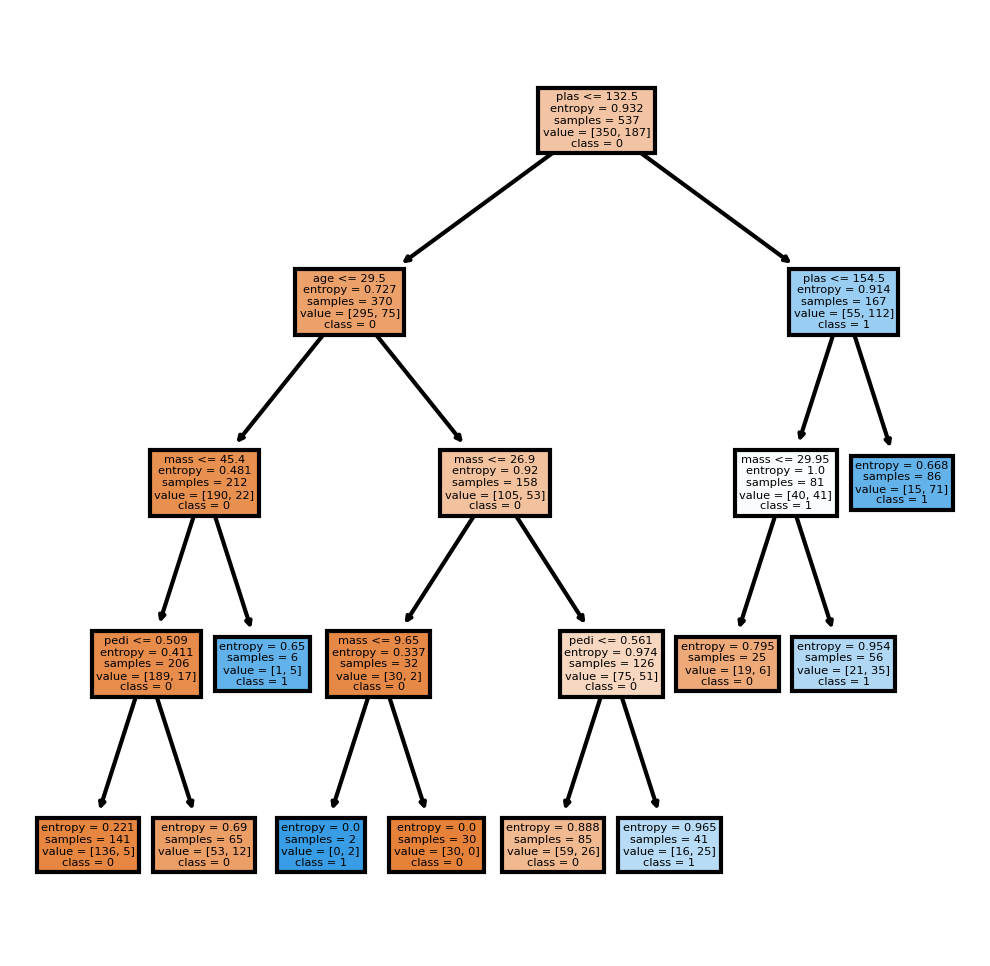

In [ ]:
fn=X_train.columns
cn=['0','1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf1,feature_names = fn,  class_names=cn, filled=True)
fig.savefig('Classifier 1.png')

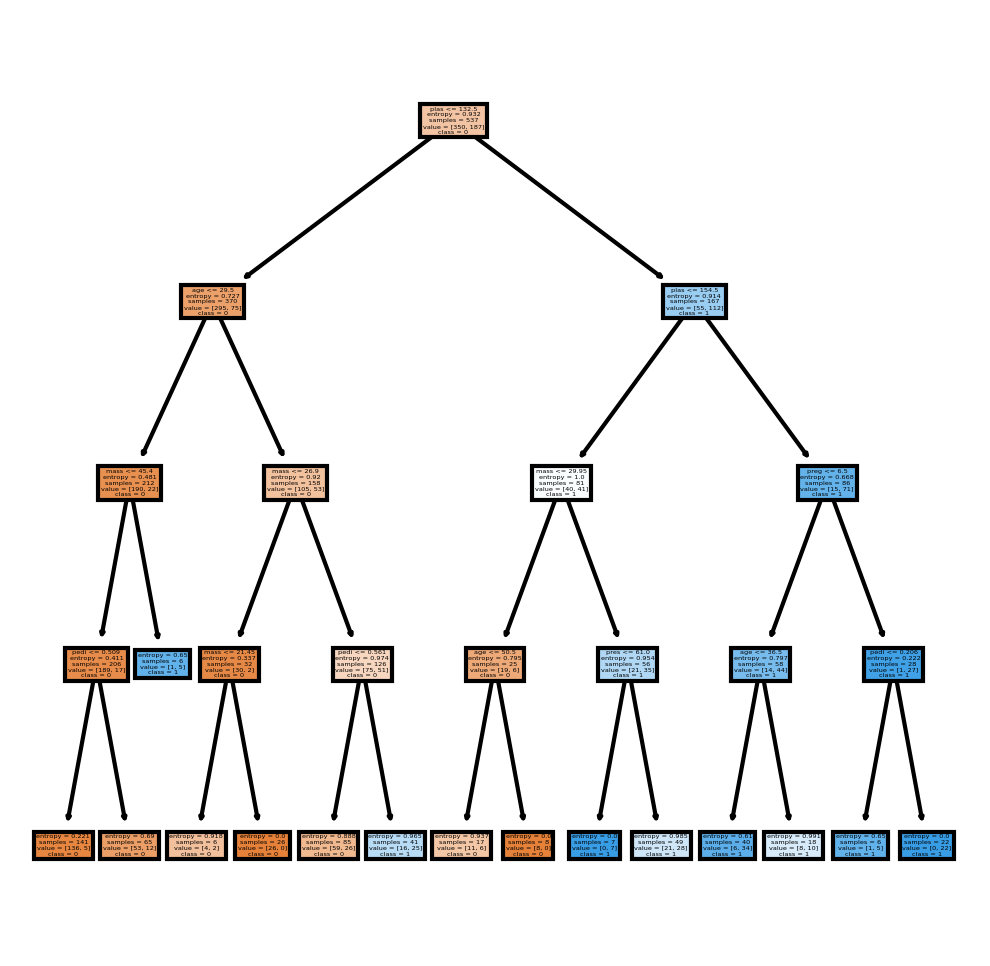

In [ ]:
fn=X_train.columns
cn=['0','1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf2,feature_names = fn,  class_names=cn, filled=True)
fig.savefig('Classifier 2.png')

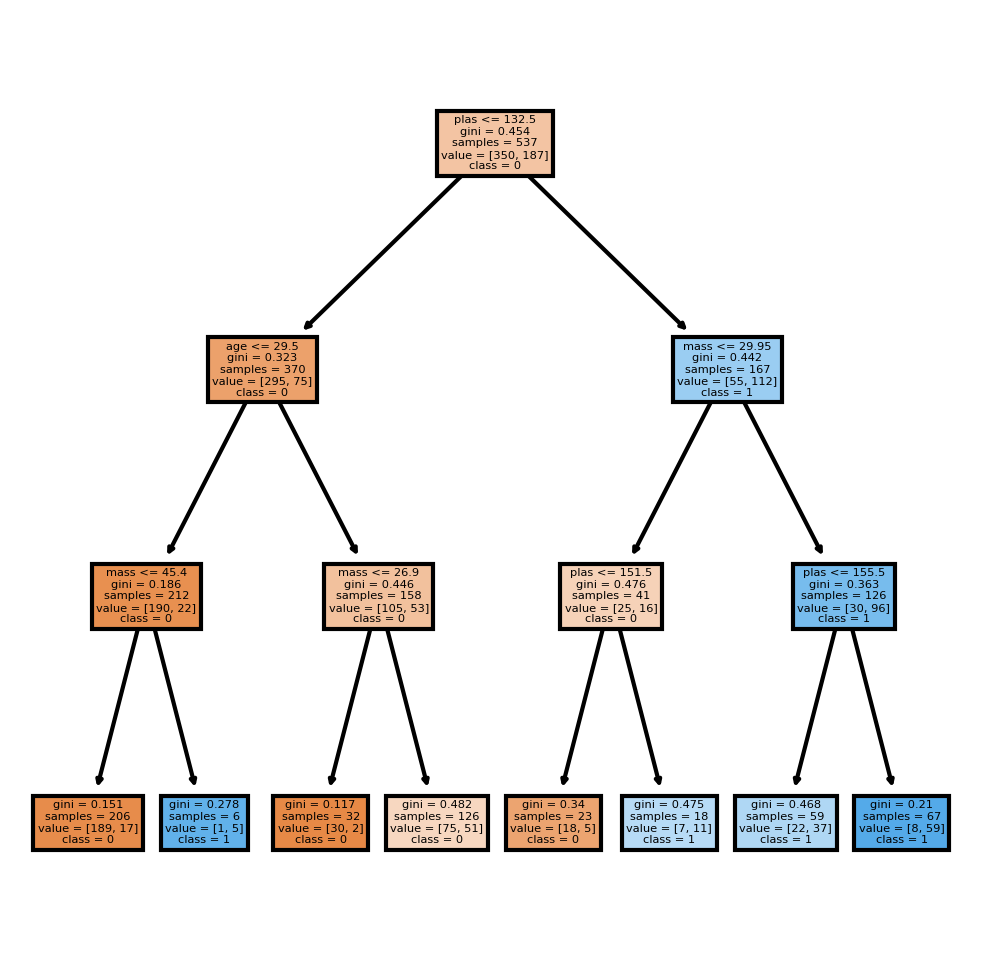

In [ ]:
fn=X_train.columns
cn=['0','1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf3,feature_names = fn,  class_names=cn, filled=True)
fig.savefig('Classifier 3.png')

# Méthode 2 

Pour cette méthode nous allons utiliser des fonctionnalités présentes dans une ancienne version de scikit learn, pour ce faire nous devons utiliser la portion de code suivante et importer ces différents objets

In [ ]:
!pip install --upgrade scikit-learn==0.22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

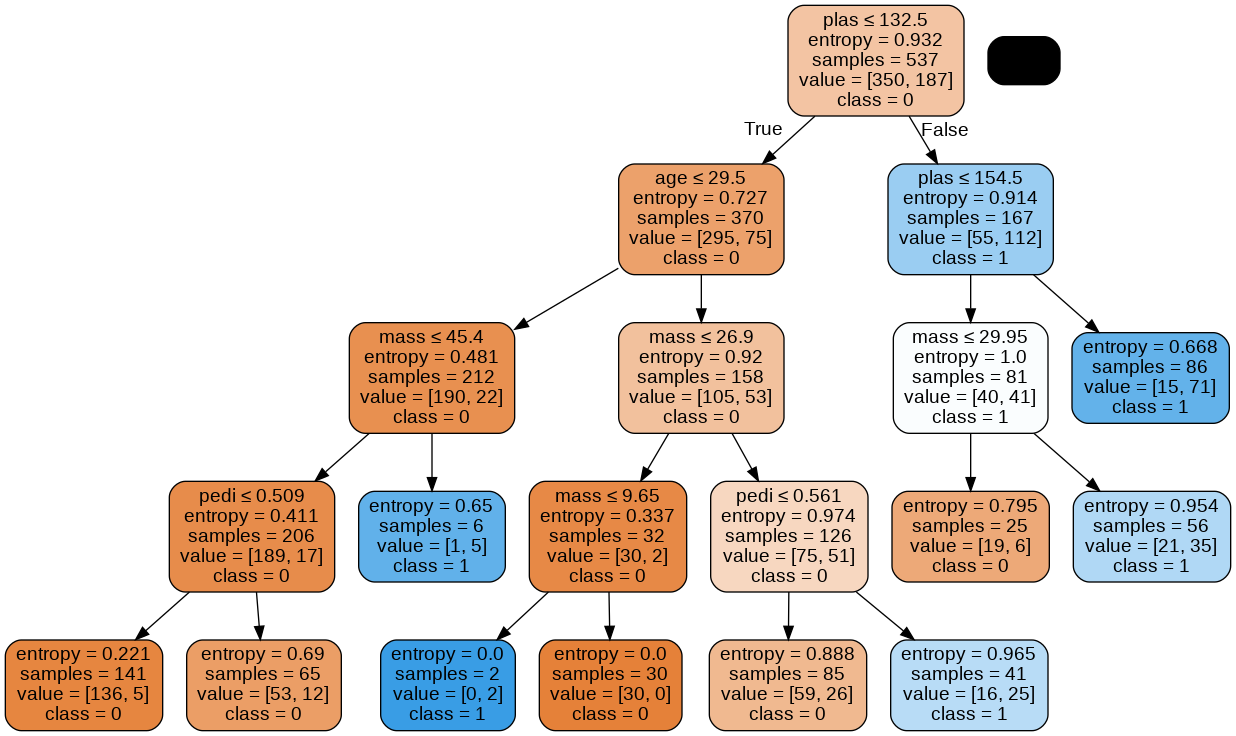

In [ ]:
dot_data = StringIO()
export_graphviz(clf1, out_file=dot_data,filled=True, rounded=True,special_characters=True,feature_names = X_train.columns.to_list(),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Clf1 diabetes tree.png')
Image(graph.create_png())

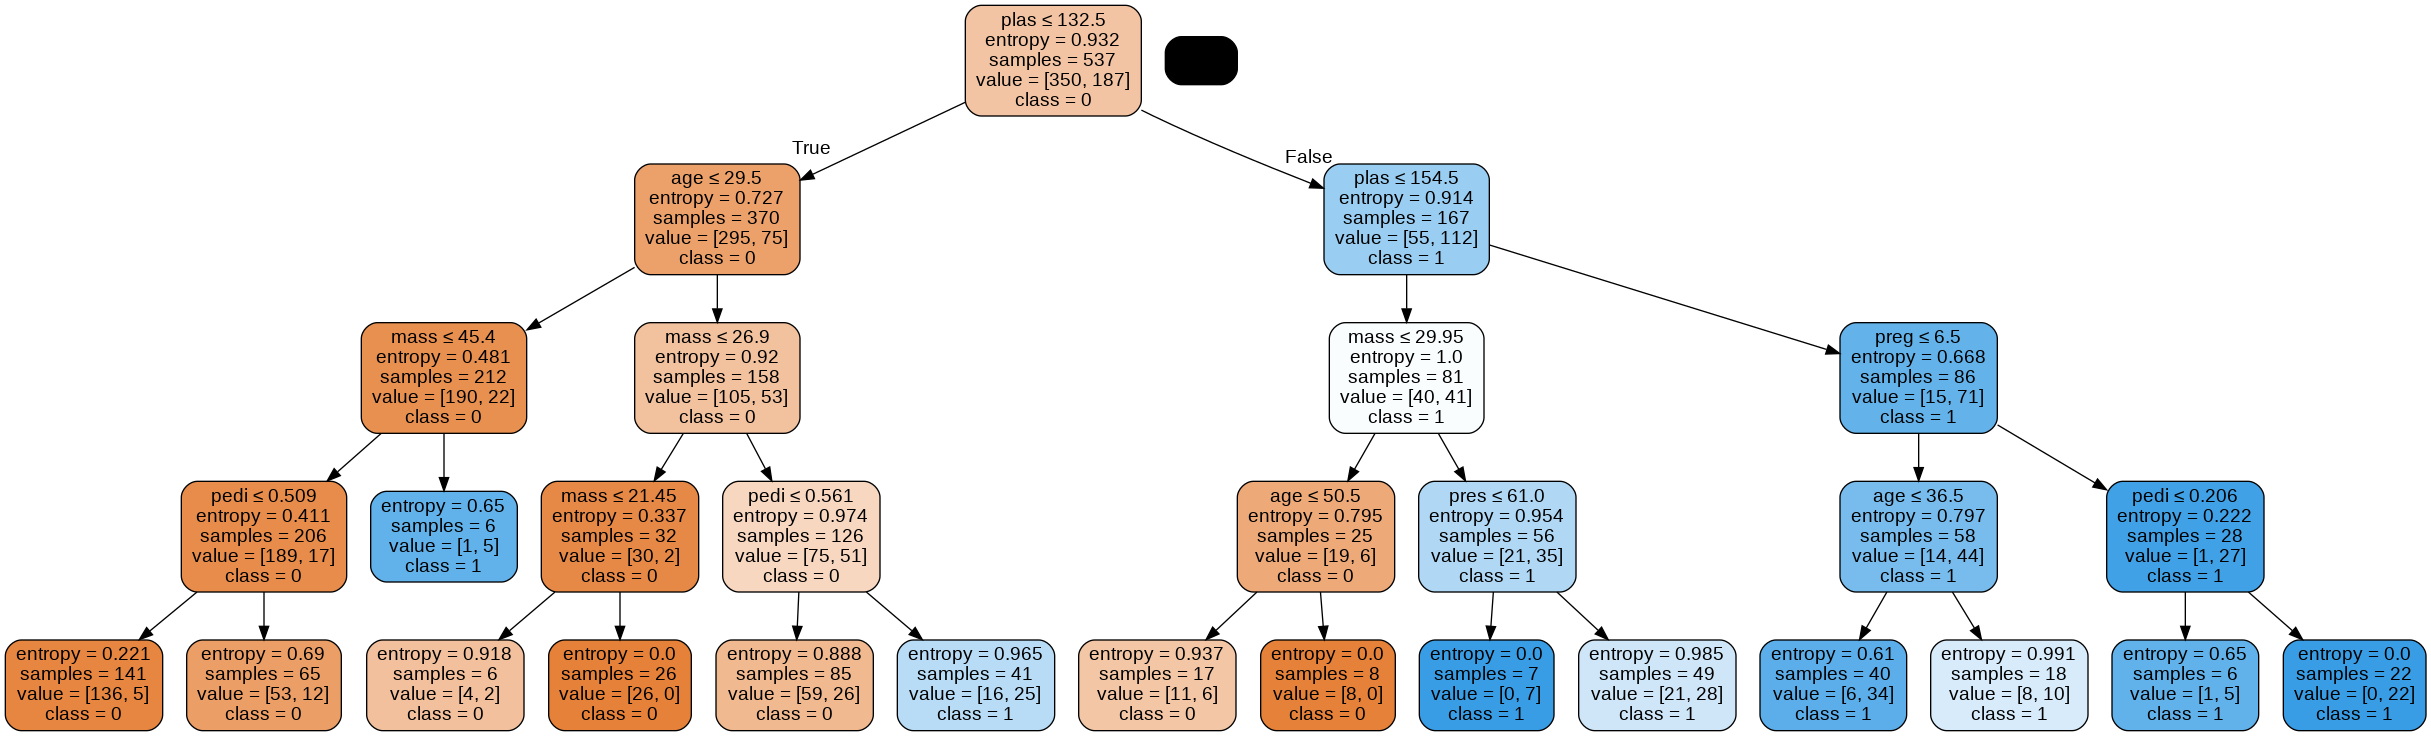

In [ ]:
dot_data = StringIO()
export_graphviz(clf2, out_file=dot_data,filled=True, rounded=True,special_characters=True,feature_names = X_train.columns.to_list(),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Clf2 diabetes tree.png')
Image(graph.create_png())

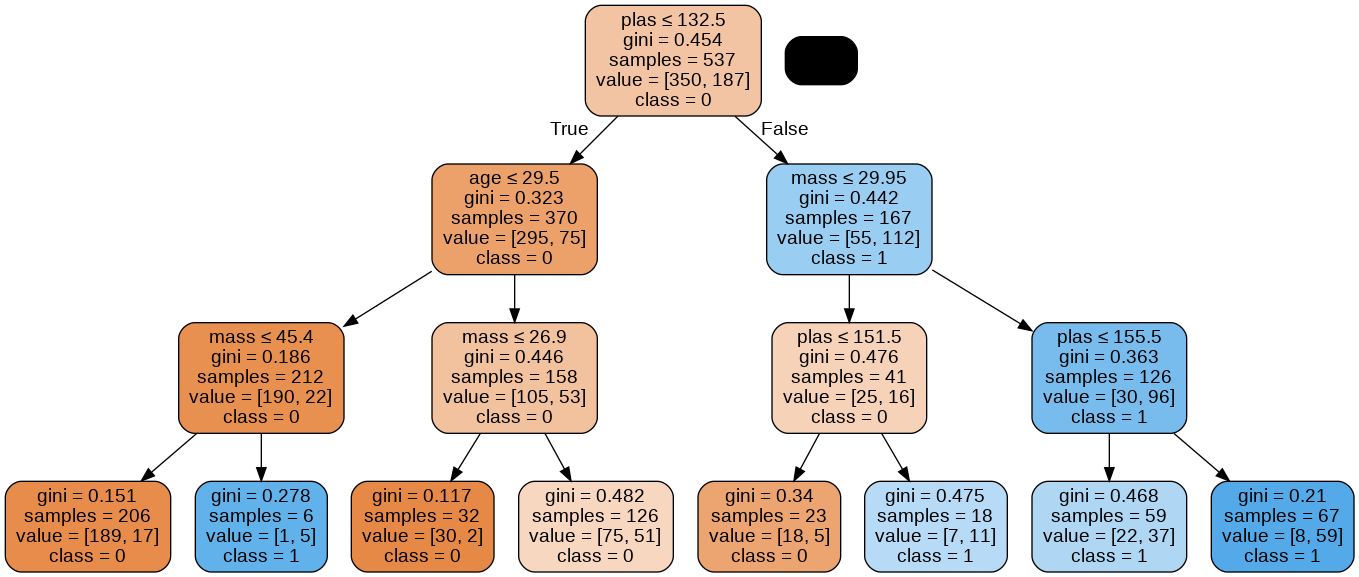

In [ ]:
dot_data = StringIO()
export_graphviz(clf3, out_file=dot_data,filled=True, rounded=True,special_characters=True,feature_names = X_train.columns.to_list(),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Clf3 diabetes tree.png')
Image(graph.create_png())

# Calcul des scores, Cross validation et métriques de comparaison

Afin de déterminer le meilleur modèle parmis nos différentes tentatives d'entrainement, nous allons utiliser différentes métriques pour les comparer, ces métriques seront calculées sur le testing set et ont pour but de comparer les différentes performances des modèles. Nous allons donc nous intéresser aux aspects suivants : 

1) la précision du modèle, elle nous permet de dégager une idée générale sur la précision de notre modèle, cependant elle ne prend pas forcément en compte tous les paramètres, nottament la classe sur laquelle il y a le plus d'erreur ou d'autres paramètres

2) La précision moyenne des cross validation, nous allons effectuer 10 étapes de cross validation et comparer les valeurs moyennes et la variance des score obtenus par chaque modèle. Cela nous permet de quantifier la robustesse de notre modèle et sa précision.

3) Les matrices de confusion des modèles, ces matrices nous permettent d'évaluer les prédictions en prenant en compte le taux de faux négatif, faux positif, vrai négatif et vrai positif, ainsi on a une vision plus locale des performances des modèles en fonction de nos prédictions et de leurs classes. Dans le cas d'une application médicale, cela semble plutot pertinent de prendre en compte ces facteurs car on va avoir tendance à réduire dans notre situation le taux de faux négatif au maximum et augmenter le taux de vrai positif car les patients ont besoin d'être pris en charge au plus vite et donc il ne faut pas rater la classification par rapport à ces aspects.

4) Les F1 score des différents modèles est un métrique qui permet de connaitre la fiabilité à bien prédire les individus positif. Ainsi nous allons chercher à maximiser ce score

5) les courbes ROC/AUC

6) les taux de bonnes prédictions en fonction des classes

7) Le recall

In [ ]:
clf1score=clf1.score(X_test, y_test) #computing the score for classifier 1
clf2score=clf2.score(X_test, y_test) #computing the score for classifier 1
clf3score=clf3.score(X_test, y_test) #computing the score for classifier 1

In [ ]:
scoresclf1 = cross_val_score(clf1, X_train, y_train, cv=10) #computing the cross validations score for classifier 1
scoresclf2 = cross_val_score(clf2, X_train, y_train, cv=10) #computing the cross validations score for classifier 2
scoresclf3 = cross_val_score(clf3, X_train, y_train, cv=10) #computing the cross validations score for classifier 3
print(" for classifier 1, %0.2f is the accuracy with a standard deviation of %0.2f" % (scoresclf1.mean(), scoresclf1.std())) #printing the values of cross val score for classifier 1
print(" for classifier 2, %0.2f is the accuracy with a standard deviation of %0.2f" % (scoresclf2.mean(), scoresclf2.std())) #printing the values of cross val score for classifier 2
print(" for classifier 3, %0.2f is the accuracy with a standard deviation of %0.2f" % (scoresclf3.mean(), scoresclf3.std())) #printing the values of cross val score for classifier 3

 for classifier 1, 0.74 is the accuracy with a standard deviation of 0.06
 for classifier 2, 0.73 is the accuracy with a standard deviation of 0.06
 for classifier 3, 0.75 is the accuracy with a standard deviation of 0.05


In [ ]:
matrix1=confusion_matrix(y_test, ypredtest1) #computing confusion matrix for clf1
matrix2=confusion_matrix(y_test, ypredtest2) #computing confusion matrix for clf2
matrix3=confusion_matrix(y_test, ypredtest3) #computing confusion matrix for clf3

In [ ]:
TN1,FP1,FN1,TP1 = matrix1[1][1],matrix1[0][1],matrix1[1][0],matrix1[0][0]  #getting confusion matrix values for clf1
classerror11,classerror01,FNrate1,TPrate1=FP1/(TP1+FP1),TN1/(TN1+FN1),FP1/np.sum(matrix1),TP1/np.sum(matrix1) #computing different metrics for clf1
print('True Positive', TP1)
print('True Negative', TN1)
print('False Positive', FP1)
print('False Negative', FN1)
TN2,FP2,FN2,TP2= matrix2[1][1],matrix2[0][1],matrix2[1][0],matrix2[0][0] #getting confusion matrix values for clf1
print('True Positive', TP2)
print('True Negative', TN2)
print('False Positive', FP2)
print('False Negative', FN2)
classerror12,classerror02,FNrate2,TPrate2=FP2/(TP2+FP2),TN2/(TN2+FN2),FP2/np.sum(matrix2),TP2/np.sum(matrix2) #computing the different rates for clf2
TN3,FP3,FN3,TP3 = matrix3[1][1],matrix3[0][1],matrix3[1][0],matrix3[0][0] #getting confusion matrix values for clf1
print('True Positive', TP3)
print('True Negative', TN3)
print('False Positive', FP3)
print('False Negative', FN3)
classerror13,classerror03,FNrate3,TPrate3=FP3/(TP3+FP3),TN3/(TN3+FN3),FP3/np.sum(matrix3),TP3/np.sum(matrix3) #computing the different rates for clf3
print(classerror11,classerror01,FNrate1,TPrate1) #printing the different values
print(classerror12,classerror02,FNrate2,TPrate2) #printing the different values
print(classerror13,classerror03,FNrate3,TPrate3) #printing the different values

True Positive 127
True Negative 50
False Positive 23
False Negative 31
True Positive 127
True Negative 50
False Positive 23
False Negative 31
True Positive 129
True Negative 39
False Positive 21
False Negative 42
0.15333333333333332 0.6172839506172839 0.09956709956709957 0.5497835497835498
0.15333333333333332 0.6172839506172839 0.09956709956709957 0.5497835497835498
0.14 0.48148148148148145 0.09090909090909091 0.5584415584415584


In [ ]:
F1score1=f1_score(y_test, ypredtest1) #computing F1 score for clf1
F1score2=f1_score(y_test, ypredtest2) #computing F1 score for clf2
F1score3=f1_score(y_test, ypredtest3) #computing F1 score for clf3

In [ ]:
y_score1 = clf1.predict_proba(X_test)[:, 1]
y_score2 = clf2.predict_proba(X_test)[:, 1]
y_score3 = clf3.predict_proba(X_test)[:, 1]
# Average precision score
average_precision1 = average_precision_score(y_test, y_score1) 
average_precision2 = average_precision_score(y_test, y_score2)
average_precision3 = average_precision_score(y_test, y_score3)
print(average_precision1,average_precision2,average_precision3)

0.635612097683817 0.6450816960549207 0.6398274461983046


In [ ]:
from sklearn.metrics import precision_score, recall_score

0.6985636233075141


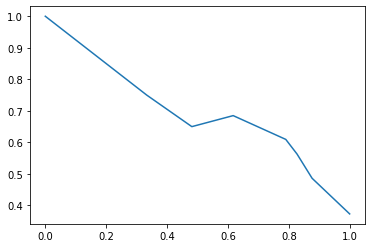

0.6771394528844366


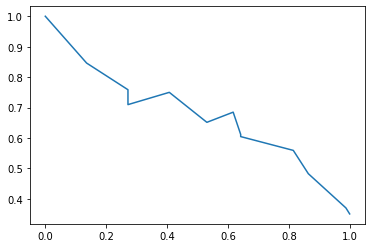

0.700637375243448


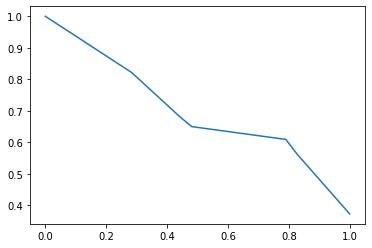

In [ ]:
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score1)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall,precision)
print(auc_precision_recall)
plt.plot(recall,precision)
plt.show()

recall=recall_score(y_test, ypredtest1)
precision=precision_score(y_test, ypredtest1)

precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_score2)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall2 = auc(recall2, precision2)
print(auc_precision_recall2)
plt.plot(recall2, precision2)
plt.show()

recall2=recall_score(y_test, ypredtest2)
precision2=precision_score(y_test, ypredtest2)

precision3, recall3, thresholds3 = precision_recall_curve(y_test, y_score3)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall3 = auc(recall3, precision3)
print(auc_precision_recall3)
plt.plot(recall3, precision3)
plt.show()

recall3=recall_score(y_test, ypredtest3)
precision3=precision_score(y_test, ypredtest3)

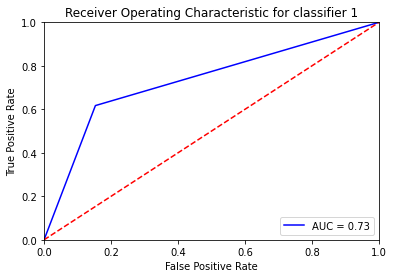

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf1.predict_proba(X_test)
preds = ypredtest1
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc1 = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for classifier 1')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC-AUC classifier 1.png")
plt.show()

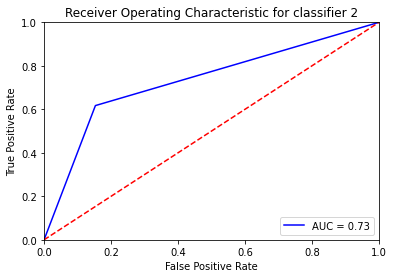

In [ ]:
probs = clf2.predict_proba(X_test)
preds = ypredtest2
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc2 = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for classifier 2')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC-AUC classifier 2")
plt.show()

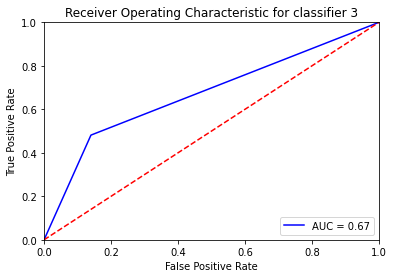

In [ ]:
probs = clf3.predict_proba(X_test)
preds = ypredtest3
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc3 = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for classifier 3')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC-AUC classifier 3")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Binary class Precision-Recall curve for classifier 1: AP=0.64')

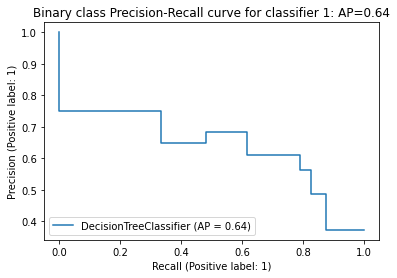

In [ ]:
disp = plot_precision_recall_curve(clf1, X_test, y_test)
disp.ax_.set_title('Binary class Precision-Recall curve for classifier 1: '
                   'AP={0:0.2f}'.format(average_precision1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Binary class Precision-Recall curve for classifier 2: AP=0.65')

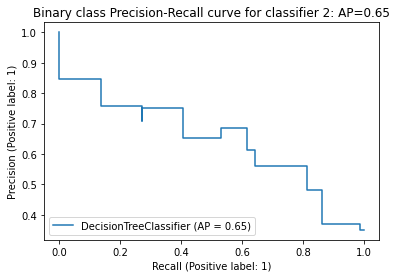

In [ ]:
disp = plot_precision_recall_curve(clf2, X_test, y_test)
disp.ax_.set_title('Binary class Precision-Recall curve for classifier 2: '
                   'AP={0:0.2f}'.format(average_precision2))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Binary class Precision-Recall curve for classifier 3: AP=0.64')

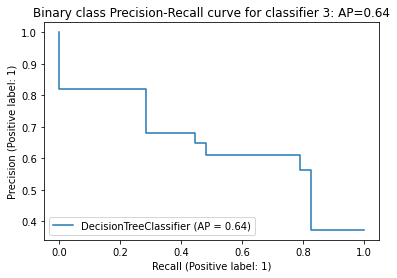

In [ ]:
disp = plot_precision_recall_curve(clf3, X_test, y_test)
disp.ax_.set_title('Binary class Precision-Recall curve for classifier 3: '
                   'AP={0:0.2f}'.format(average_precision3))

# Création du DataFrame final pour comparaison

Afin de pouvoir comparer les différents modèles, nous allons utiliser le dataframe compilant toutes les informations nescessaires à la comparaison. Pour faire cela nous allons représenter graphiquement les différentes valeurs et comparer les différentes informations. Avant cela nous allons sauvegarder les différents résultats dans un fichier csv. 

In [ ]:
datacompare = {'Score':[clf1score,clf2score,clf3score], 'Cross Validation mean':[scoresclf1.mean(),scoresclf2.mean(),scoresclf3.mean()],'Cross Validation standard deviation':[scoresclf1.std(),scoresclf2.std(),scoresclf3.std()],'ROC-AUC':[roc_auc1,roc_auc2,roc_auc3],'F1 score':[F1score1,F1score2,F1score3], 'Confusion Matrix':[matrix1,matrix2,matrix3],'True positive':[TP1,TP2,TP3],'True positive rate ':[TPrate1,TPrate2,TPrate3], 'False positive':[FP1,FP2,FP3],'True negative':[TN1,TN2,TN3],'False negative':[FN1,FN2,FN3],'False negative rate ':[FNrate1,FNrate2,FNrate3],'Class error on 0 class':[classerror01,classerror02,classerror03],'Class error on 1 class':[classerror11,classerror12,classerror13], 'average precision score':[average_precision1,average_precision2,average_precision3], 'recall':[recall,recall2,recall3], 'precision':[precision,precision2,precision3], 'auc-precision-recal':[auc_precision_recall,auc_precision_recall2,auc_precision_recall3]}  
  
# Creates pandas DataFrame.  
dfcompare = pd.DataFrame(datacompare, index =['Classifier 1', 'Classifier 2','Classifier 3'])  
dfplot=dfcompare
dfcompare=dfcompare.transpose()
dfcompare

,Classifier 1,Classifier 2,Classifier 3
Score,0.766234,0.766234,0.727273
Cross Validation mean,0.744934,0.730049,0.754123
Cross Validation standard deviation,0.056133,0.060309,0.046545
ROC-AUC,0.731975,0.731975,0.670741
F1 score,0.649351,0.649351,0.553191
Confusion Matrix,"[[127, 23], [31, 50]]","[[127, 23], [31, 50]]","[[129, 21], [42, 39]]"
True positive,127,127,129
True positive rate,0.549784,0.549784,0.558442
False positive,23,23,21
True negative,50,50,39


#Visualisation des valeurs et décision sur le modèle à conserver

Maintenant que nous avons tous les indicateurs, nous allons les analyser afin de déterminer quel est le modèle le plus adapté. 

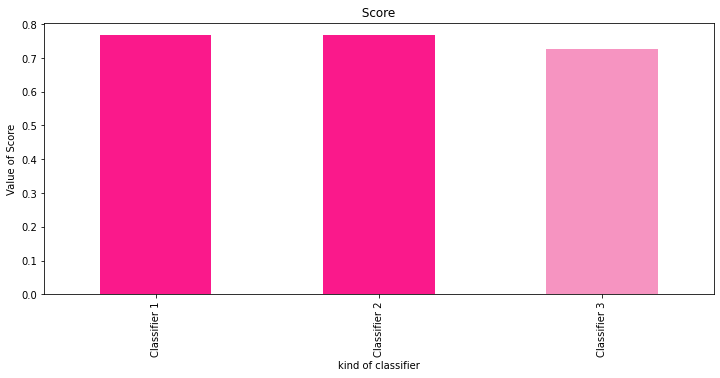

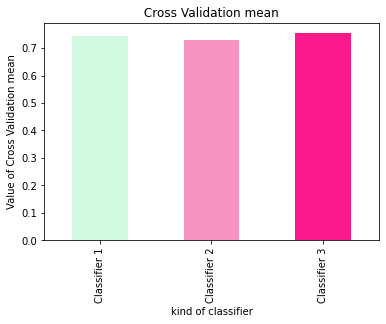

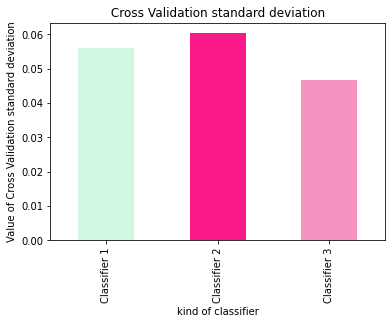

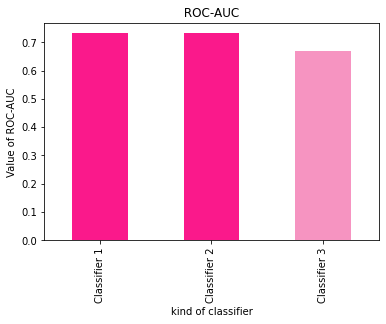

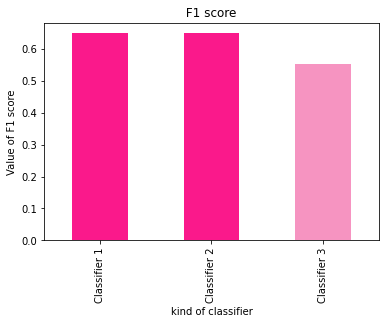

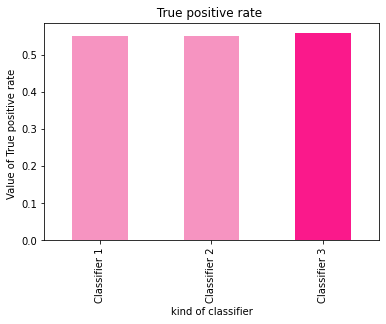

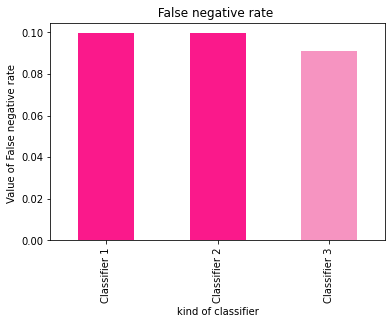

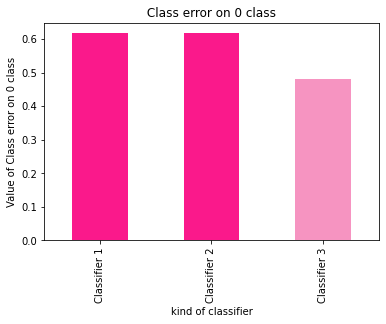

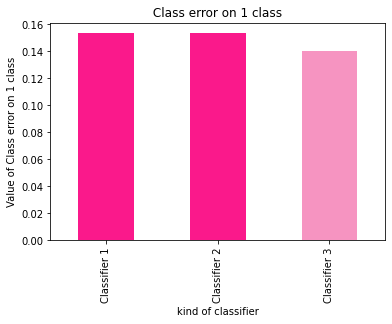

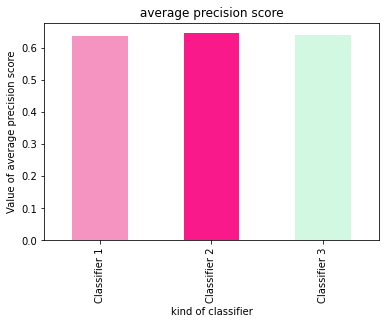

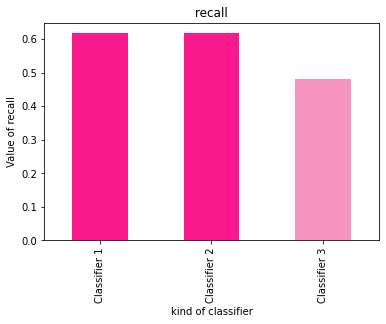

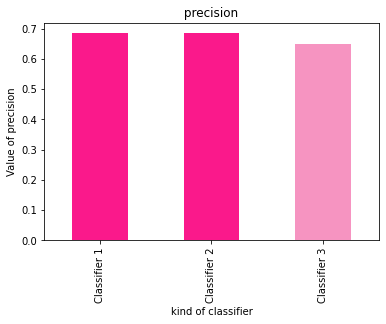

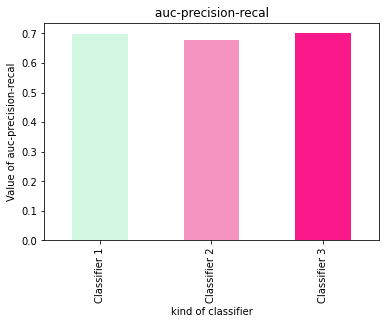

In [ ]:
plt.figure(figsize=(12, 5)) #setting the figure size
labels = [f"{i}" for i in dfplot.index.to_list()] #extracting the different label
labelscol = [f"{i}" for i in dfplot.columns.to_list()]
for i in range(0,len(labelscol)):
  if type(dfplot[labelscol[i]][1])==type(dfplot["auc-precision-recal"][1]):
    colorslab = [{min(dfplot[labelscol[i]])<p<max(dfplot[labelscol[i]]): '#D3F8E2', 
                  p>=max(dfplot[labelscol[i]]): '#FA198B',
                  p<=min(dfplot[labelscol[i]]): '#F694C1'
                  }[True] for p in dfplot[labelscol[i]]]
    ax = dfplot[labelscol[i]].plot(kind="bar",color=colorslab) #ploting the different bars
    ax.set_title(' '+ str(labelscol[i])+' ') #setting the tittle
    ax.set_xlabel("kind of classifier") #setting de x labels
    ax.set_ylabel("Value of "''+str(labelscol[i])+'') #setting the y label
    ax.set_xticklabels(labels) # setting the x ticks labels
    plt.savefig(' '+str(labelscol[i])+' ',dpi=300) #saving the figure
    plt.show() #showing the graph
  else:
    i=i
    


Ces figures nous permettent de comparer les différentes valeurs

Ainsi notre algorithme ayant pour objectif d'accompagner au mieux le patient, les facteurs les plus déterminants dans la recherche du meilleur modèle vont être : 

Le F1 score car il donne les informations les plus pertinentes dans ce type de classification avec un dataset non balancé selon notre variable de prédiction. En effet le F1 score permet de prendre en compte le recall et la sensibilité qui sont les facteurs les plus importants dans ce type de classification ou l'on souhaite prédire plus de faux positifs que de faux négatifs car il vaut mieux approfondir les examens pour quelqu'un de non malade que de laisser passer quelqu'un de malade. En effet dans notre cas on va chercher le F1 score le plus grand et le recall le plus élevé également.

Enfin nous pouvons si il y a un doute exploiter les auc du ROC et F1 score pour pouvoir déterminer le modèle le plus robuste.

Ainsi dans notre cas nous séléctionnerons le modèle numéro 1 car ce dernier possède le F1 score le plus élévé avec le recall le plus élévé également. Son score et son roc auc étant le plus élévé également, cela fait de ce modèle le plus adapté que nous conserverons !

In [ ]:
dfcompare.to_csv('/content/comparaison.csv',index=True) #Saving the Dataframe

# Ce travail à été réalisé par Julien Séailles, je vous remercie pour le temps que vous avez pris pour le parcourir et nous espèrons sincèrement que ce travail vous aura plu !

[Si jamais vous souhaitez avoir accès au google collab, il est disponible juste ici : https://colab.research.google.com/drive/133D_yTLh00iTmPiu09A2fN4qNPgFoXlr?usp=sharing](https://colab.research.google.com/drive/133D_yTLh00iTmPiu09A2fN4qNPgFoXlr?usp=sharing)